# Guide to Extracting Data w/ APIs from the Withings Body+ Scale

<img src="https://helios-i.mashable.com/imagery/reviews/004D6FxeJ3thoEUqJ7bum9h/hero-image.fill.size_1248x702.v1648656157.png" width="500"/>

Are smart TVs, smartphones, or smart watches not enough? Introducing the [Withings Body+ Scale](https://www.withings.com/us/en/body-plus), a smart scale that can not only weigh you, but also leverage its Wi-Fi capabilities to enable you to store your historical weight data for your viewing pleasure. While this notebook is meant for the Body+ Scale, it can be easily adapted to any other Withings scale with minor modifications.

Also note that you need to set up your Withings Body+ Scale prior to running this notebook. To do this, simply follow the instructions on the app to (1) pair your phone to your scale and (2) connect your scale to your home internet.

If you want to know more about Withings Body+ Scale, see the [README](https://github.com/alrojo/wearipedia/tree/main/wearables/withings-scale-bodyplus) for a detailed analysis of performances, sensors, data privacy, and extraction pipelines.

The API makes the following parameters available:

Parameter Name  | Sampling Frequency 
-------------------|------------------
Weight (kg)      |  Per weighing
Fat Free Mass (kg) | Per weighing
Fat Ratio (%) | Per weighing
Fat Mass Weight (kg) | Per weighing
Muscle Mass (kg) | Per weighing
Hydration (kg) | Per weighing
Bone Mass (kg) | Per weighing


<br><br>
In this guide, we sequentially cover the following **five** topics to extract from the Withings API:
1. **Setup** 
    - 1.1: We include some details about what a clinical study participant may be expected to do, assuming you use the public API as we did.
2. **Authentication/Authorization** 
    - This requires a couple extra steps on your part
3. **Data extraction**
    - Due to our own limited sample size, which precludes long time horizon data analysis, we include a data extraction step that loads an artificial dataset we randomly generate.
4. **Data exporting** 
    - We export the data via Pandas DataFrame into file formats compatible by R, Excel, and Matlab
6. **Adherence** 
    - We simulate non-adherence by dynamically removing datapoints from our simulated data.
6. **Visualization** 
    - We look at trends in both weight and fat (%) over time (months).
7. **Advance Visualization** 
    - 4.1: We plot a calendar heatmap of weight measurements every day, revealing which days the user has used the scale.
    - 4.2: We also look at how weight varies over the time of day and downsample weight to a single measurement per day.
8. **Outlier Detection and Data Cleaning** 
    - We detect outliers in our data and filter them out.
9. **Data analysis** 
    - We aggregate body weight by time of day, then conduct a brief statistical analysis to check whether body weight indeed increases after a meal.


Disclaimer: this notebook is purely for educational purposes. All of the data currently stored in this notebook is purely *synthetic*, meaning randomly generated according to rules we created. Despite this, the end-to-end data extraction pipeline has been tested on our own data, meaning that if you enter your own credentials on your own Colab instance, you can visualize your own *real* data. That being said, we were unable to thoroughly test the timezone functionality, though, since we only have one account, so beware.

# 1. Setup

## 1.1 Study participant setup and usage

To set up the scale itself so that you can run this notebook, download the Withings app and follow the instructions on the app. The app will pair via bluetooth to the scale, creating an interface to connect the scale to Wi-Fi. In our experience, this process was frought with difficulties.

Note that the Wi-Fi network must have no captive portal, only simple username / password authentication. This means that connecting the scale to Wi-Fi may be challenging on a university campus setting, where Wi-Fi is hidden behind layers of authentication. One potential workaround is to view the serial number (which is the same as the MAC address) and register the MAC address through the IT department, which should allow a connection to university campus Wi-Fi.

## 1.2 Wearipedia Library Install
Relevant libraries are imported below. Just run the code to import all the libraries.

In [128]:
#@title Library import + setup

# sneak in the library imports etc. here :)

# We randomly generate a large artificial dataset to make our demo analysis
# more interesting and to avoid using real data. This is not needed for
# data extraction.
!rm -f random_data.csv && wget -q https://gist.githubusercontent.com/stanford-health-wearables/3e5bdd4dfc06a4290038fabf34732ca3/raw/c99a50c1d943903c867364dc6c9a11d83fb4e42a/random_data.csv

# upgrade scipy, since we need "intercept_stderr"
# from https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html
!pip install --upgrade scipy -q

import requests
import urllib
import json
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage import gaussian_filter
from scipy import stats

In [130]:
!pip install wearipedia
!pip install july -q # for calendar plotting

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [131]:
import wearipedia
device = wearipedia.get_device('withings/bodyplus')

# 2. Authentication/Authorization

To be able to make requests to the API, the easiest way is to use the public developer API. This section roughly follows the steps outlined [here](https://developer.dexcom.com/authentication) on their website.

First, follow the non-colab steps listed below:

1. Visit the [developer portal](https://developer.withings.com/) and click "Open Developer Dashboard" on the top right.
2. Once logged in, click "Add an app".
3. For now, you can just click "I don't know" under "Services", accept terms of use, and click "Next".
5. Put whatever you want under "Application Name" (we used `withings-test`), anything under "Application Description", and "https://wbsapi.withings.net/v2/oauth2" under Registered URLs, then click "Done".
    - NOTE: "registered URLs" is intended to be a URL to a webserver you control and can receive requests from. However, in this notebook we are simply using it as a placeholder, as this functionality is not strictly necessary for obtaining your data.

In the end, you should see something like the below.

<img src="https://i.imgur.com/ttWojjU.png"></img>

Now we can proceed with the rest of the notebook.

To be able to make requests to the API and extract the data we need, we need to first issue an access token. This (ephemeral) access token will serve as our key to the data. While, you don't necessarily need to be familiar with how the issuing of the authtoken occurs, you can learn more about it by visiting [the official Withings tutorial](https://developer.withings.com/developer-guide/v3/integration-guide/public-health-data-api/get-access/oauth-web-flow/).

In [132]:
#@title 6. Enter your credentials below (from the application you just created) or click synthetic if you do not want real data
CLIENT_ID = "b59fbc3bfeb891334682a31d4c4e0658885caeb4c6c4f9cb2c68391e4c0c7dd9" #@param {type:"string"}
CUSTOMER_SECRET = "dbc476e4d9893b6d8bbc88cd4b4e9b2ae369b5dca479f330982feb01a76fabd8" #@param {type:"string"}
use_synthetic = True #@param {type:"boolean"}
credentials = {"client_id": CLIENT_ID, "client_secret": CUSTOMER_SECRET}
if not use_synthetic:
  device.authenticate(credentials)


7. Now visit the above URL and click "Allow this app", and copy the **entire** URL you were redirected to into the input text field above that says "redirect url below: ." Note that if you mess up once, you have to go through the above URL again (including clicking "Allow this app"). Also, the URL is only valid for 30 seconds, so be quick in pasting!

Now that we have our access token, we can begin making requests to the API! This access token will last only three hours, though, so you would need to re-do step 7 if three hours pass.

# 3. Data extraction

Here, data extraction is pretty simple! All we need to do is make a GET request 
with the right query parameters. See [the overall health data API page](https://
developer.withings.com/developer-guide/v3/integration-guide/public-health-data-api/data-api/all-available-health-data) or the ["Measure" endpoints specifically](https://developer.withings.com/api-reference#operation/measure-getmeas) for more info, if you want to change up these query parameters for your own usage.

Data can be extracted via wearipedia, our open-source Python package that unifies dozens of complex wearable device APIs into one simple, common interface.

First, we'll set a date range and then extract all of the data within that date range. You can select whether you would like synthetic data or not with the checkbox.

Below you can uncheck the "use_synthetic" box to instead use your own *real* data via Withings API calls!

In [144]:
#@title Extract data via the API!
#set start and end dates - this will give you all the data from 2000-01-01 (January 1st, 2000) to 2100-02-03 (February 3rd, 2100), for example
start_date='2020-01-01' #@param {type:"string"}
end_date='2022-05-18 ' #@param {type:"string"}
params = {"start": start_date, "end": end_date}

df = device.get_data("measurements", params=params)
df

,date,Weight (kg),Fat Ratio (%)
0,2021-06-01 17:29:07.850010,65.496852,26.422520
1,2021-06-01 21:30:29.707118,67.692261,28.952624
2,2021-06-01 21:43:37.667575,69.551421,26.804885
3,2021-06-02 15:00:05.023369,67.698075,27.121633
4,2021-06-04 14:08:06.231484,66.924077,27.786819
...,...,...,...
524,2022-05-16 09:06:05.873155,70.474852,26.735455
525,2022-05-16 19:17:28.898534,67.057496,26.081832
526,2022-05-16 14:19:25.434828,66.779464,28.884893
527,2022-05-17 19:29:52.880084,69.114482,28.742685


# 4. Data Exporting

In this section, we export all of this data to formats compatible with popular scientific computing software (R, Excel, Google Sheets, Matlab). Specifically, we will first export to JSON, which can be read by R and Matlab. Then, we will export to CSV, which can be consumed by Excel, Google Sheets, and every other popular programming language.

## Exporting to JSON (R, Matlab, etc.), CSV, and XLSX (Excel, Google Sheets, R, Matlab, etc.)

Exporting to all these formats is fairly simple since we return a Pandas DataFrame. We export each datatype separately (JSON only) and also export a complete version that includes all simultaneously.

In [140]:
# set which format you prefer to export
use_JSON = True #@param {type:"boolean"}
use_CSV = True #@param {type:"boolean"}
use_Excel = True #@param {type:"boolean"}

if use_JSON:
  for column in df.columns:
    column_list = df[column].tolist()

    # If the first column contains Timestamp objects, convert to strings
    if isinstance(column_list[0], pd.Timestamp):
        column_list = [x.strftime("%Y-%m-%d %H:%M:%S") for x in column_list]

    # Write the list to a JSON file with its corresponding type as the title
    filename = column + ".json"
    with open(filename, 'w') as f:
        json.dump(column_list, f)

  # Convert the df to dictionary and make sure TimeStamps are strings
  df_JSON = df
  df_JSON.loc[:, 'date'] = df_JSON['date'].apply(lambda x: str(x))
  df_JSON = df_JSON.to_dict(orient='records')

  # Write the dictionary to a JSON file
  with open('data.json', 'w') as outfile:
      json.dump(df_JSON, outfile)

if use_CSV:
  # Write the dataframe to a CSV file
  df.to_csv("data.csv", index=False)

if use_Excel:
  # Write the dataframe to an Excel file
  df.to_excel("data.xlsx", index=False)


/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


Feel free to open the file viewer (see left pane) to look at the outputs!


# 5. Adherence

The device simulator already automatically randomly deletes small chunks of the day. In this section, we will simulate non-adherence over longer periods of time from the participant (day-level and week-level).

Then, we will detect this non-adherence and give a Pandas DataFrame that concisely describes when the participant has had their device on and off throughout the entirety of the time period, allowing you to calculate how long they've had it on/off etc.

We will first delete a certain % of blocks either at the day level or week level, with user input.

In [141]:
#@title Non-adherence simulation
block_level = "day" #@param ["day", "week"]
adherence_percent = 0.29 #@param {type:"slider", min:0, max:1, step:0.01}

In [142]:
if block_level == "day":
    block_length = 1
elif block_level == "week":
    block_length = 7

num_blocks = len(df['date'].tolist()) # length of entries in DF using the 1st column
num_blocks_to_keep = int(adherence_percent * num_blocks)

df_adherence = df
df_adherence = df_adherence.reset_index(drop=True) # reset the index
idxes = np.random.choice(np.arange(num_blocks), replace=False, size=num_blocks_to_keep)
df_adherence = df_adherence.drop(idxes.tolist())


And now we have significantly fewer datapoints! This will give us a more realistic situation, where participants may take off their device for days or weeks at a time.

Now let's detect non-adherence. We will return a Pandas DataFrame sampled at everyday.

In [146]:
start_date = df.iloc[0]['date']
end_date = df.iloc[-1]['date']
weight_concat = []
for weight in df_adherence['Weight (kg)'].tolist():
    weight_concat += [weight]

ts_col = pd.date_range(start_date, end_date, freq="D", normalize=True)
using_arr = np.zeros(len(ts_col))
for i, dt in enumerate(df_adherence['date']):
    ts = pd.Timestamp(pd.to_datetime(dt).date())
    idxes = np.where(ts_col == ts)[0]
    if len(idxes) >= 1:
      using_arr[idxes[0]] = 1

df_adherence_detect = pd.DataFrame()
df_adherence_detect['timestamp'] = ts_col
df_adherence_detect['is_using'] = using_arr.astype('bool')

We can plot this out, and we get adherence at a daily frequency throughout the entirety of the data collection period.

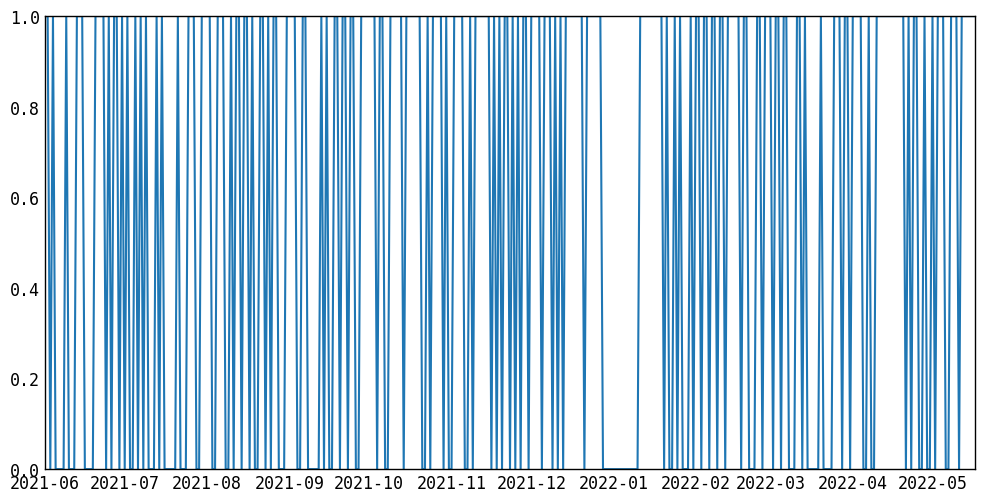

In [147]:
plt.figure(figsize=(12, 6))
plt.plot(df_adherence_detect.timestamp, df_adherence_detect.is_using)

We can also turn this into a list of start and stop points.

In [148]:
from itertools import groupby

def contiguous_regions(a):
    i = 0
    res = []

    for k, g in groupby(a):
        l = len(list(g))
        if k:
            res.append((i,i+l))
        i += l

    return res

start_stops = []
for x in contiguous_regions(df_adherence_detect.is_using):
    if x[0] >= 0 and x[0] < len(df_adherence_detect) and x[1] >= 0 and x[1] < len(df_adherence_detect):
        start_stops.append((df_adherence_detect.timestamp[x[0]], df_adherence_detect.timestamp[x[1]]))
start_stops

[(Timestamp('2021-06-01 00:00:00'), Timestamp('2021-06-03 00:00:00')),
 (Timestamp('2021-06-04 00:00:00'), Timestamp('2021-06-05 00:00:00')),
 (Timestamp('2021-06-09 00:00:00'), Timestamp('2021-06-10 00:00:00')),
 (Timestamp('2021-06-13 00:00:00'), Timestamp('2021-06-16 00:00:00')),
 (Timestamp('2021-06-20 00:00:00'), Timestamp('2021-06-24 00:00:00')),
 (Timestamp('2021-06-25 00:00:00'), Timestamp('2021-06-26 00:00:00')),
 (Timestamp('2021-06-27 00:00:00'), Timestamp('2021-06-29 00:00:00')),
 (Timestamp('2021-06-30 00:00:00'), Timestamp('2021-07-01 00:00:00')),
 (Timestamp('2021-07-02 00:00:00'), Timestamp('2021-07-03 00:00:00')),
 (Timestamp('2021-07-05 00:00:00'), Timestamp('2021-07-06 00:00:00')),
 (Timestamp('2021-07-07 00:00:00'), Timestamp('2021-07-08 00:00:00')),
 (Timestamp('2021-07-09 00:00:00'), Timestamp('2021-07-10 00:00:00')),
 (Timestamp('2021-07-13 00:00:00'), Timestamp('2021-07-14 00:00:00')),
 (Timestamp('2021-07-15 00:00:00'), Timestamp('2021-07-16 00:00:00')),
 (Time

## 6. Visualization

We've extracted lots of data, but what does it look like?

In this section, we will be visualizing our two measurements in a simple, customizable plot! This plot is intended to provide a starter example for plotting, whereas later examples emphasize deep control and aesthetics. You are able to choose parameters for when a specific intervention started and which measurement you desire to plot. 

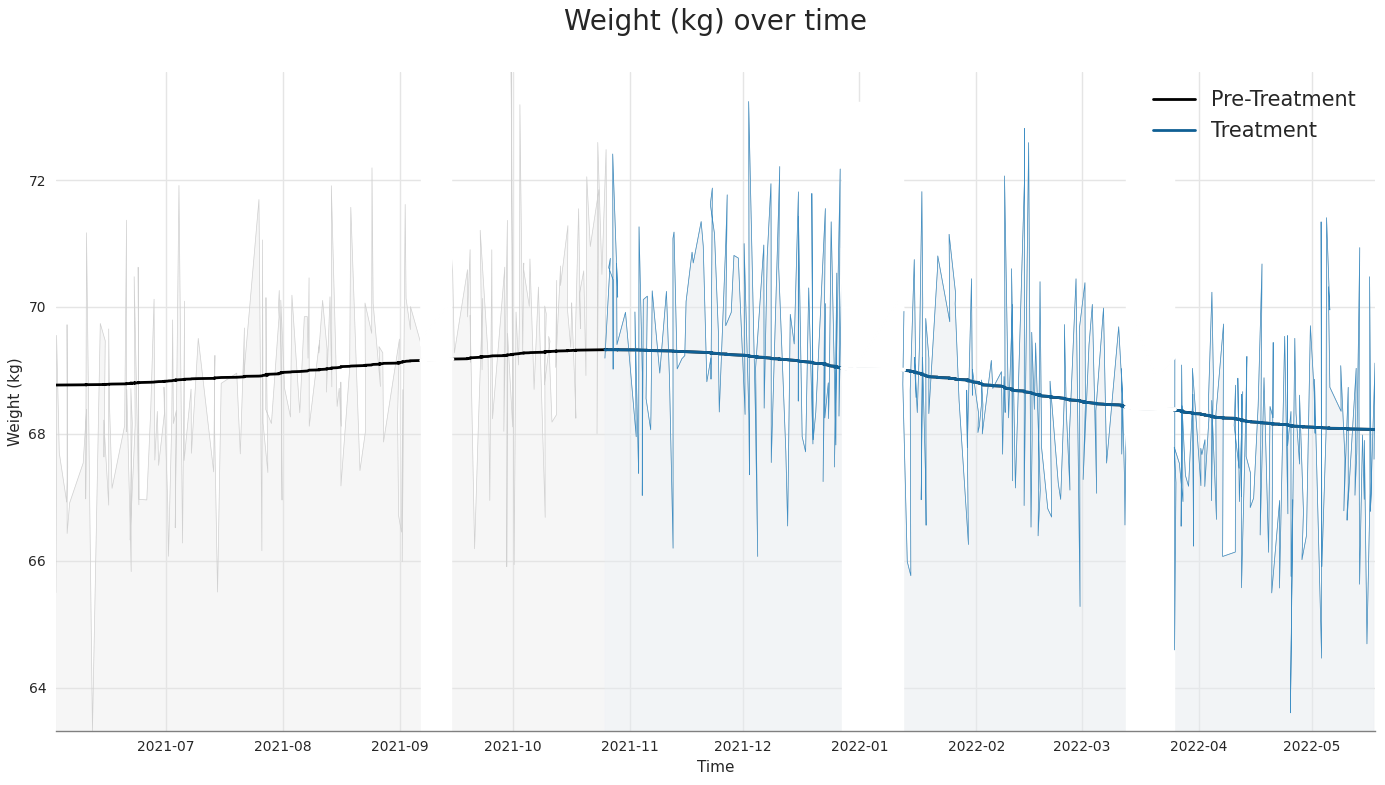

In [150]:
#@title Plot all of the data

from scipy.ndimage import gaussian_filter

# set treatment start index at a specific entry number
TREATMENT_START_IDX=200#@param {type:"number"}

# set measurement to plot
MEASUREMENT_TYPE='Weight (kg)'#@param['Weight (kg)', 'Fat Ratio (%)']

# 2 days
MIN_NEEDED_FOR_BREAK = 5 * 24 * 3600

x_timestamp = np.array(df.date.apply(lambda x: x.timestamp()))

# get the gaps. we include [6] as well because when you do np.diff,
# it actually leaves out exactly one element
differences = np.concatenate((np.diff(x_timestamp), [6]))

# interpret a gap (i.e. when a user takes off the device for some prolonged
# period of time) as any two measurements that are taken more than
# MIN_NEEDED_FOR_BREAK seconds apart
gap_idxes = np.where(differences > MIN_NEEDED_FOR_BREAK)[0]

with plt.style.context('seaborn'):
    plt.figure(figsize=(14,8))

    # filter the weight so that it looks smoother
    filtered = gaussian_filter(df[MEASUREMENT_TYPE], 100)

    # plot the weight curve and its filtered counterpart
    plt.plot(df.date, df[MEASUREMENT_TYPE], linewidth=.5, color='#d1d1d1')
    plt.plot(df.date, filtered, linewidth=2, color='black', label='Pre-Treatment')

    # plot the fill from x-axis up to weight curve
    plt.fill_between(df.date, df[MEASUREMENT_TYPE], color='#e3e3e3', alpha=0.3)

    # overlay treatment color
    plt.plot(df.date.iloc[TREATMENT_START_IDX:],
             df[MEASUREMENT_TYPE].iloc[TREATMENT_START_IDX:],
             linewidth=0.5, color='#3f8fc5')
    plt.plot(df.date.iloc[TREATMENT_START_IDX:],
             filtered[TREATMENT_START_IDX:],
             linewidth=2, color='#0f5f94', label='Treatment')
    plt.fill_between(df.date.iloc[TREATMENT_START_IDX:],
                     df[MEASUREMENT_TYPE].iloc[TREATMENT_START_IDX:],
                     color='#eaf1f6', alpha=0.3)

    # overlay gaps
    for gap_idx in gap_idxes:
        plt.plot(df.date.iloc[gap_idx-3:gap_idx+3], df[MEASUREMENT_TYPE].iloc[gap_idx-3:gap_idx+3], linewidth=2, color='white')
        plt.plot(df.date.iloc[gap_idx-3:gap_idx+3], filtered[gap_idx-3:gap_idx+3], linewidth=3, color='white')
        plt.fill_between(df.date.iloc[gap_idx-3:gap_idx+3], df[MEASUREMENT_TYPE].iloc[max(gap_idx-100,0):gap_idx+100].max(), color='white')


    plt.title(MEASUREMENT_TYPE + ' over time', fontsize=20)
    plt.ylabel(MEASUREMENT_TYPE)
    plt.xlabel('Time')

    # set background color *inside the figure*
    plt.gca().set_facecolor(color='white')

    # add horizontal grid
    plt.gca().grid(axis='x', color='#e5e5e5')
    plt.gca().grid(axis='y', color='#e5e5e5', which='major')

    # ensure the bottom axis is slightly darker and extends all the way
    # to the left
    plt.gca().spines['bottom'].set_edgecolor('grey')
    plt.gca().spines['bottom'].set_linewidth(1)
    plt.gca().spines['bottom'].set_visible(True)

    if MEASUREMENT_TYPE == 'Weight (kg)':
      plt.ylim(df['Weight (kg)'].min(), df['Weight (kg)'].max())
    else:
      plt.ylim(10, 40)
    plt.legend(prop={'size': 15})

    plt.tight_layout()

# 7. Advance Visualization

Now we'll do some more advanced plotting that at times features hardcore matplotlib hacking with the benefit of aesthetic quality.

Note that the timestamps that were extracted above correspond to days demarcated by midnight *not necessarily in UTC*, but rather where the user lives. To be precise, the timestamps themselves are in UTC, but the day element they belong to is determined by their location of residence.

## 7.1: Calendar Plot of Trends 

First, it's important to know when the user has been wearing the device as well as having a day-to-day plot of the user's weight and fat ratio trends. That way, we know the high-level time frame for the measurements, and can know where to focus analysis on.

To figure this out, we'll make a calendar plot. Fortunately, this idea is easy to execute with the use of july, a custom library that allows us to create beautiful calendar plots. We'll interpret step count as a proxy for usage and plot colors accordingly.

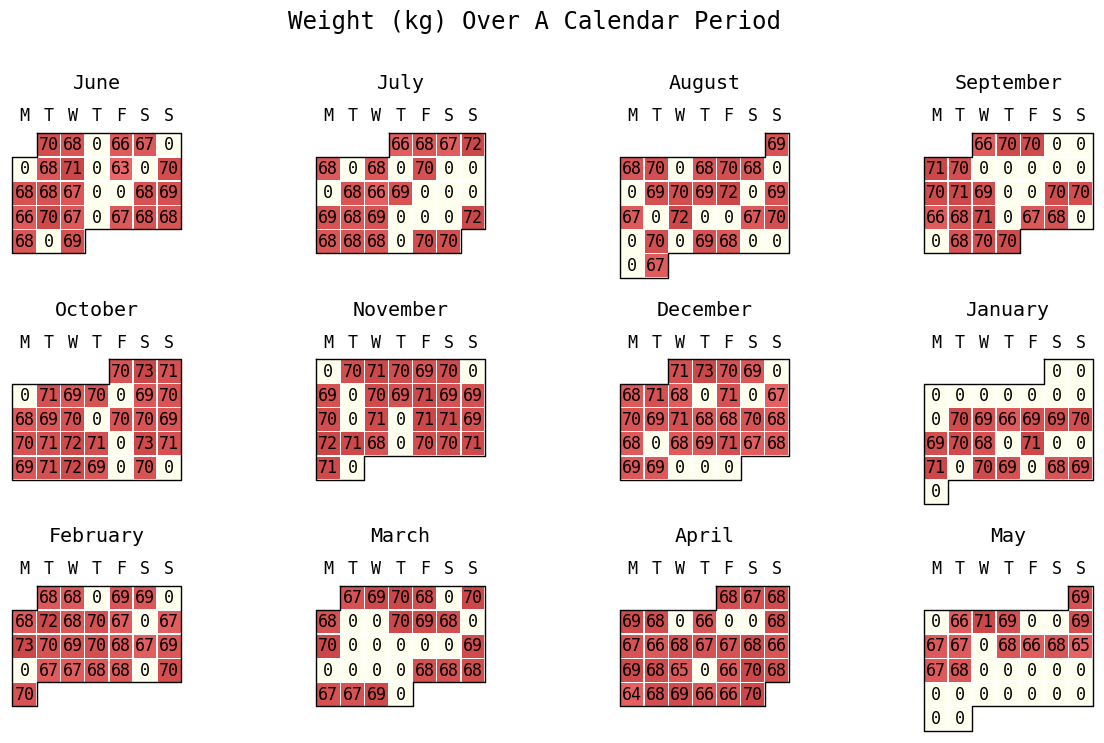

In [151]:
# sum across hour axis
import july
# set measurement to plot
VAR_TYPE='Weight (kg)'#@param['Weight (kg)', 'Fat Ratio (%)']


# copy so we can restore the rcParams later on; july changes it
IPython_default = plt.rcParams.copy()

july.calendar_plot(df.date, df[VAR_TYPE], value_label=True, weeknum_label=False, title=False)
plt.suptitle(VAR_TYPE + ' Over A Calendar Period', fontsize="x-large", y=1.03)
plt.show()  # suppress output from above line

## 7.2: Time of day

It might also be interesting to look at how these quantities vary over the time of day. We'll aggregate all measurements by the hour of the day they were taken, then do a violin plot.

<ipython-input-152-7bff225abe78>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Hour of the day'] = df.date.apply(lambda x: x.hour)


Text(0.5, 1.0, 'Weight by time of day')

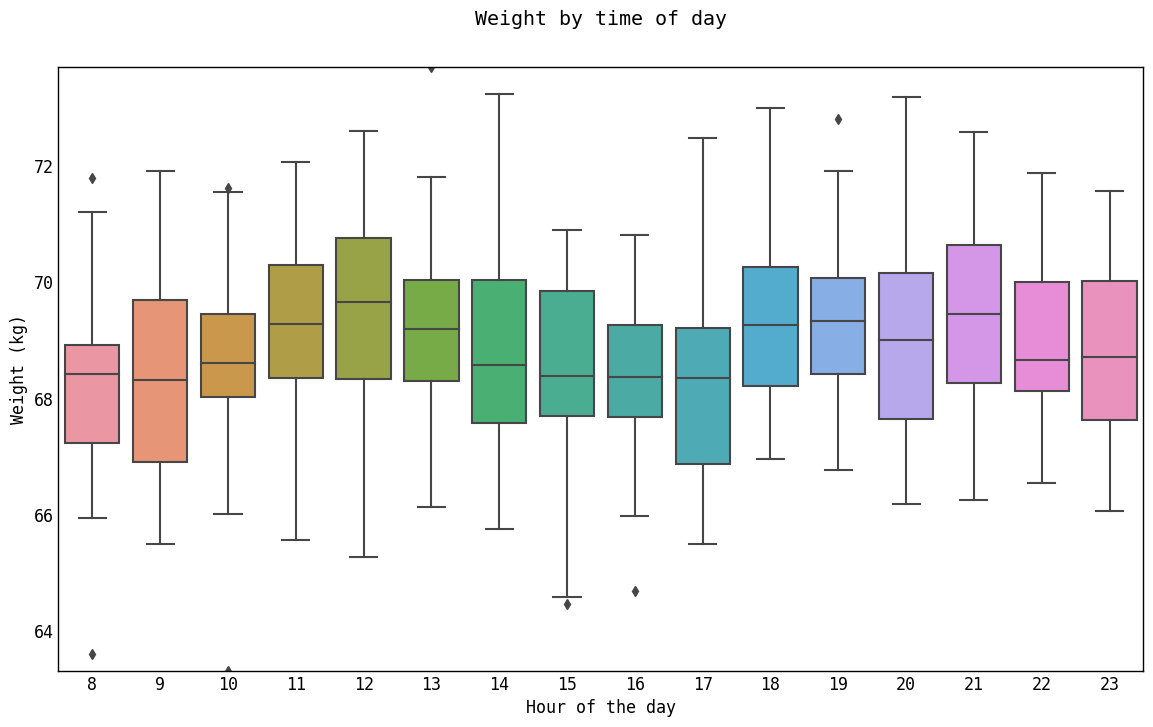

In [152]:
#@title Plot weight by time of day
df['Hour of the day'] = df.date.apply(lambda x: x.hour)

plt.figure(figsize=(14,8))
sns.boxplot(x='Hour of the day', y='Weight (kg)', data=df)
plt.title('Weight by time of day')

Looks like things vary quite a bit by time of day, and the user also seems to have taken more than one measurement per day on average (given that we have ~1400 measurements over the course of just two years). What if we want to just get a single weight value for each day the user has weighed themselves?

Let's solve this problem by doing the following. Choose a time to be the canonical weighing time, say 5pm (technically speaking, 5pm-6pm). If a user has weighed themselves during that time interval, do nothing. If a user weighed themselves at some other time, say 3pm, then just add an offset corresponding to the average offset between weighings at 3pm and 5pm.

If a user has weighed themselves at multiple points other than 5pm, just average their corrected weight values.

To deduce the average offsets in the first place, just go through and find each instance where the user weighed themselves at 5pm, look in the neighborhood of 5 days within that day, and compute the offsets for the hours captured by those measurements.

In [153]:
#@title Get the offsets
days = df.date.apply(lambda x: x.timestamp()) / (24 * 3600)
days = days.reset_index(drop=True)

#need to reset index for when there is start/end truncation
df_temp = df
df_temp = df_temp.reset_index(drop=True)

# note that index 17 should be garbage, we don't care about it
offsets = [[] for i in range(24)]

for idx in np.where(df['Hour of the day'] == 17)[0]:
    to_offset = df_temp['Hour of the day'].iloc[np.where(np.abs(days[idx] - days) < 5)[0]]

    for i, val in zip(to_offset.index, to_offset):
        offsets[val].append(df_temp['Weight (kg)'].iloc[idx] - df_temp['Weight (kg)'].iloc[i])


def compute_mean(x):
    if len(x) > 0:
        return np.mean(x)
    else:
        return 0

offsets = [compute_mean(offset) for offset in offsets]

Now that we have our offsets we can create a new dataframe that is just the downsampled version of what we already had, but now just one value per day!

In [154]:
#@title Get downsampled dataframe
downsampled_dict = []

for day in range(int(days.iloc[0]), int(days.iloc[-1])):
    # check if there are any measurements here
    day_idxes = np.where(days.apply(lambda x: int(x)) == day)[0]

    # if there are, do offset
    corrected_weights = []
    for day_idx in day_idxes:
        corrected_weight = df_temp['Weight (kg)'].iloc[day_idx] + offsets[df_temp['Hour of the day'].iloc[day_idx]]
        corrected_weights.append(corrected_weight)

    # save
    if len(corrected_weights) > 0:
        row = {
            'date': datetime.fromtimestamp(day * 24 * 3600),
            'Weight (kg)': np.mean(corrected_weights)
        }

        downsampled_dict.append(row)

downsampled_df = pd.DataFrame.from_dict(downsampled_dict)
downsampled_df

,date,Weight (kg)
0,2021-06-01,66.908199
1,2021-06-02,67.313172
2,2021-06-04,67.365394
3,2021-06-05,67.111786
4,2021-06-08,67.175483
...,...,...
237,2022-05-12,66.999659
238,2022-05-13,67.675943
239,2022-05-14,66.816674
240,2022-05-15,64.847008


As you can see, we've now got a dataframe without any repeating days!

# 8. Outlier Detection and Data Cleaning

In this section, we will detect outliers in our extracted data and impute them.

Since there are currently no outliers (by construction, since it is simulated to have none), we will manually inject a couple.

In [155]:
df_outlier = df
df_outlier = df_outlier.reset_index(drop=True) # necessary since we truncated original indices

new_data = {'date': pd.Timestamp('2022-06-16 23:04:39.745184') ,'Weight (kg)': 155.56, 'Fat Ratio (%)': 27.5}
df_outlier = df_outlier.append(new_data, ignore_index=True)
new_data = {'date': pd.Timestamp('2022-06-17 22:04:39.745184') ,'Weight (kg)': 68.78, 'Fat Ratio (%)': 39.5}
df_outlier = df_outlier.append(new_data, ignore_index=True)

df_outlier = df_outlier.sort_values(by='date')
df_outlier = df_outlier.reset_index(drop=True) # necessary for future index searching
df_outlier

,date,Weight (kg),Fat Ratio (%),Hour of the day
0,2021-06-01 17:29:07.850010,65.496852,26.422520,17.0
1,2021-06-01 21:30:29.707118,67.692261,28.952624,21.0
2,2021-06-01 21:43:37.667575,69.551421,26.804885,21.0
3,2021-06-02 15:00:05.023369,67.698075,27.121633,15.0
4,2021-06-04 14:08:06.231484,66.924077,27.786819,14.0
...,...,...,...,...
506,2022-05-16 19:17:28.898534,67.057496,26.081832,19.0
507,2022-05-17 13:22:32.306439,67.600329,27.846957,13.0
508,2022-05-17 19:29:52.880084,69.114482,28.742685,19.0
509,2022-06-16 23:04:39.745184,155.560000,27.500000,NaN


Now that we've manually injected them, let's demonstrate that we can detect these.

We will use a simple statistical method for detecting outliers. Specifically, we will rely on the assumption that weight and fat ratio percentages roughly do not change very much from one timestep to the next, and that if there is one measurement that very clearly sticks up much higher than the rest surrounding it, then it is likely an outlier.

We will capture this notion by assuming the datapoints fit a normal distribution and calculate Z-scores for every entry. 

In [156]:
from scipy.stats import norm # necessary for normal distribution

wt_list = [x for x in df_outlier['Weight (kg)'].tolist()]
fr_list = [x for x in df_outlier['Fat Ratio (%)'].tolist()]

# Calculate mean and standard deviation of the weights and fat ratio columns
wt_mu, wt_sigma = norm.fit(wt_list)
fr_mu, fr_sigma = norm.fit(fr_list)

# Calculate the z-score for each data point
wt_z_scores = [(x - wt_mu) / wt_sigma for x in wt_list]
fr_z_scores = [(x - fr_mu) / fr_sigma for x in fr_list]
print(wt_list[-1])

68.78


We will find any elements that deviate by more than $6\sigma$ from the mean, consider these outliers, and impute their value in the original data. We will average around these outliers if possible by a singular entry before and after. In the case of the first and last entries, we will average around 2 consecutive measurements after and before (respectively).

In [157]:
wt_outlier_indices = [i for i, z in enumerate(wt_z_scores) if z >= 6 or z <= -6]
fr_outlier_indices = [i for i, z in enumerate(fr_z_scores) if z >= 6 or z <= -6]

for outlier in wt_outlier_indices:
  orig_val = wt_list[outlier]
  new_mean = orig_val
  if outlier == 0:
    new_mean += wt_list[outlier+1] + wt_list[outlier+2]
  elif outlier == len(df_outlier) - 1:
    new_mean += wt_list[outlier-1] + wt_list[outlier-2]
  else:
    new_mean += wt_list[outlier-1] + wt_list[outlier-2]
  df_outlier.iloc[outlier, df_outlier.columns.get_loc('Weight (kg)')] = new_mean / 3
  print(f'Replacing {orig_val} with ', df_outlier.iloc[outlier, df_outlier.columns.get_loc('Weight (kg)')], ' obtained by averaging around it.')
  print(f'Index in Weight (kg) array is {outlier} and the z-score of this entry was {wt_z_scores[outlier]}')

for outlier in fr_outlier_indices:
  orig_val = fr_list[outlier]
  new_mean = orig_val
  if outlier == 0:
    new_mean += fr_list[outlier+1] + fr_list[outlier+2]
  elif outlier == len(df_outlier) - 1:
    new_mean += fr_list[outlier-1] + fr_list[outlier-2]
  else:
    new_mean += fr_list[outlier-1] + fr_list[outlier-2]
  df_outlier.iloc[outlier, df_outlier.columns.get_loc('Fat Ratio (%)')] = new_mean / 3
  print(f'Replacing {orig_val} with ', df_outlier.iloc[outlier, df_outlier.columns.get_loc('Fat Ratio (%)')], ' obtained by averaging around it.')
  print(f'Index in Fat Ratio (%) array is {outlier} and the z-score of this entry was {fr_z_scores[outlier]}')


Replacing 155.56 with  97.42493708768666  obtained by averaging around it.
Index in Weight (kg) array is 509 and the z-score of this entry was 20.70907497988417


# 9. Data Analysis

Let's try to look for some trends.

## 9.1: Before and after meal

First, let's confirm that the weights after meals are greater than the weights before meals.

Note that this is slightly trickier than simply aggregating all of the weighings that occurred before a meal together and aggregating all of the weighings that occurred after a meal together, then comparing, since the user lost weight. This is because these local fluctuations are much smaller than the change due to the treatment over the course of two years, so they will be washed out.

So instead we'll compare weighings to the weighings immediately surrounding them, and see if weighings that occurred after a meal tend to be higher. First, we'll compute a new column that represents whether the weighing was before a meal, after a meal, or neither.

In [158]:
def apply_func(x):
    hour = int(x.strftime('%H'))

    if hour in [12+4,12+5]:
        return 'before'
    elif hour in [12+7,12+8,12+9]:
        return 'after'
    else:
        return 'N/A'

df['meal_relative'] = df.date.apply(apply_func)

<ipython-input-158-9dc11d949b65>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['meal_relative'] = df.date.apply(apply_func)


Now that we have this column, let's compute the deviation of each weighing to their neighboring weighings using a Gaussian filter.

In [159]:
df['weight_deviations'] = df['Weight (kg)'] - gaussian_filter(df['Weight (kg)'], sigma=100)

<ipython-input-159-cac568f65427>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['weight_deviations'] = df['Weight (kg)'] - gaussian_filter(df['Weight (kg)'], sigma=100)


Now we can finally check this hypothesis!

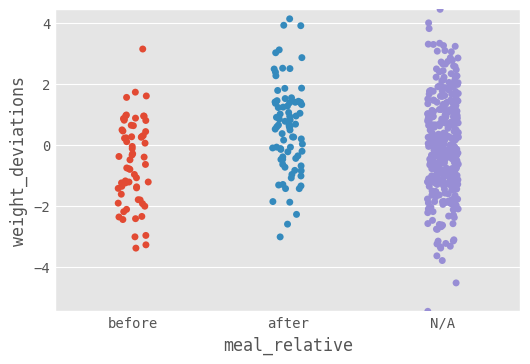

In [160]:
with plt.style.context('ggplot'):
    sns.stripplot(x='meal_relative', y='weight_deviations', data=df)

It looks like whether the user just ate a meal or not has an impact on the weight. In fact, we can check the difference in the mean of both groups below.

In [161]:
print(f'Mean of weight deviation for weighings before a meal: {df.weight_deviations[df.meal_relative == "before"].mean():.3g}')
print(f'Mean of weight deviation for weighings after a meal: {df.weight_deviations[df.meal_relative == "after"].mean():.3g}')

Mean of weight deviation for weighings before a meal: -0.554
Mean of weight deviation for weighings after a meal: 0.551


Let's check that this is significant with a two-tailed T-test.

In [162]:
result = stats.ttest_ind(df.weight_deviations[df.meal_relative == 'before'],
                         df.weight_deviations[df.meal_relative == 'after'])

print(f'P-value is {result.pvalue:.3g}')

P-value is 8.68e-06


It's significant!

## 9.2: Treatment effectiveness

While with only one person's data it is impossible to conclusively state that the treatment has or has not been effective (there is no control group), we can perform a linear regression, which provides a quantitative basis for the promising trend in weight we've seen in the plots in section 4.

Specifically, we will perform a linear regression on the datapoints $(x,y)$, where $x$ is the timestamp and $y$ is the weight, strictly after the treatment start (index 50) and check its p-value. First, we'll just plot this out to remind ourselves what the data looks like.

<ipython-input-163-ff9adfbd01e0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Timestamp'] = df.date.apply(lambda x: x.timestamp())


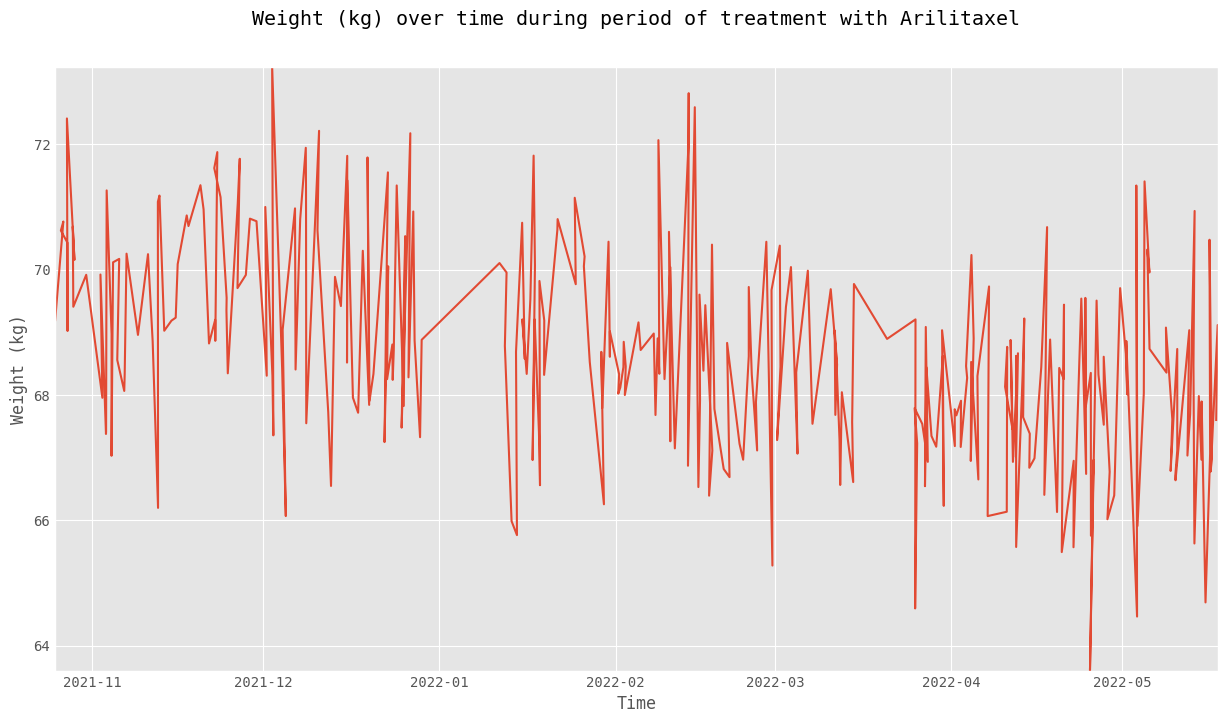

In [163]:
df['Timestamp'] = df.date.apply(lambda x: x.timestamp())
with plt.style.context('ggplot'):
    plt.figure(figsize=(15,8))
    plt.plot(df.iloc[200:, df.columns.get_loc('date')], df.iloc[200:, df.columns.get_loc('Weight (kg)')])
    plt.xlabel('Time')
    plt.ylabel('Weight (kg)')
    plt.title('Weight (kg) over time during period of treatment with Arilitaxel')

Looks pretty convincing! Let's do the statistical test now to confirm this quantitatively.

In [164]:
from scipy import stats
from scipy.stats import t

res = stats.linregress(df['Timestamp'].iloc[200:],
                       df['Weight (kg)'].iloc[200:])

tinv = lambda p, df: abs(t.ppf(p/2, df))
ts = tinv(0.05, len(df.date)-2)

print(f'Slope (95% confidence): {res.slope:.3g} +/- {ts*res.stderr:.3g}')
print(f'Intercept (95% confidence): {res.intercept:.6f}'
      f' +/- {ts*res.intercept_stderr:.6f}')
print(f'Coefficient of determination: {res.rvalue**2:.3g}')
print(f'p-value: {res.pvalue:.3g}')

Slope (95% confidence): -1.36e-07 +/- 3.15e-08
Intercept (95% confidence): 292.376765 +/- 51.870730
Coefficient of determination: 0.19
p-value: 1.01e-15


Looks significant, and the confidence intervals for the slope and y-intercept are pretty tight! Below we plot what these confidence intervals entail, visually.

Text(0.5, 1.0, 'Weight (kg) over time during period of treatment with Arilitaxel')

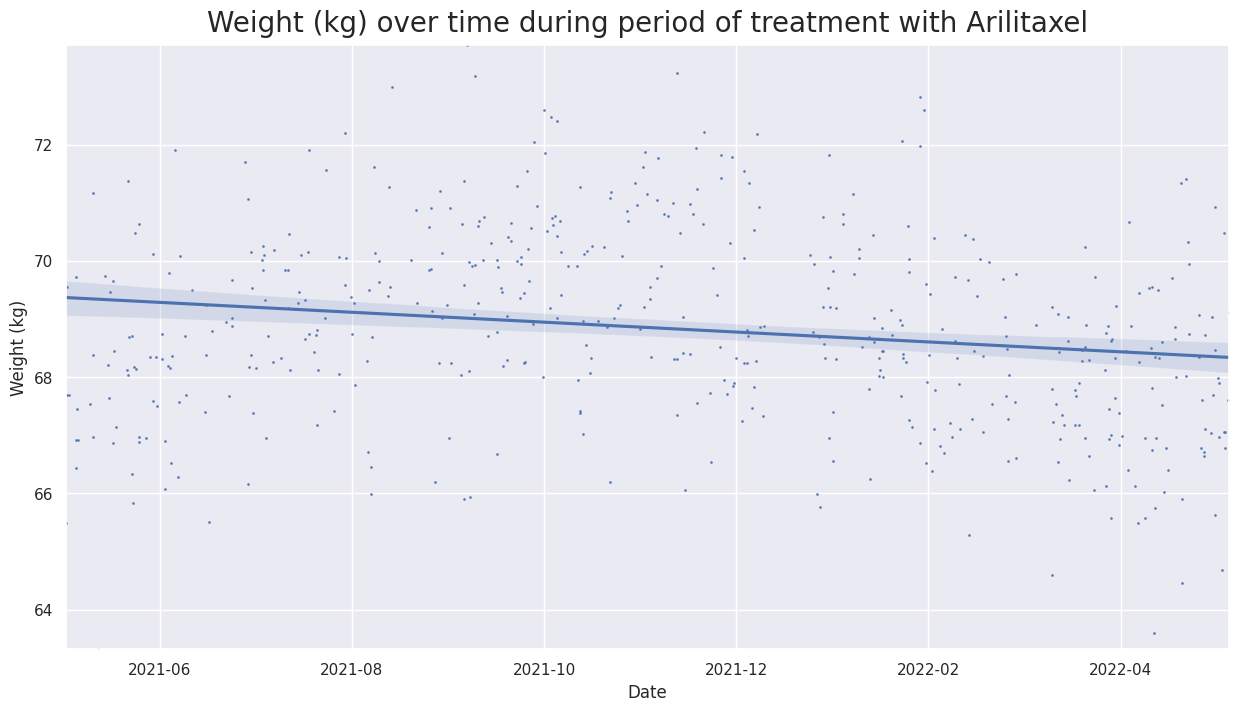

In [165]:
sns.set(rc = {'figure.figsize':(15,8)})

# Note 1: c=95 to ensure that CI is 95%
# Note 2: plotting timestamp but then replacing tick labels, since
# dates don't work with sns.regplot
sns.regplot(x='Timestamp', y='Weight (kg)', data=df, scatter_kws={'s':1}, ci=95)

ax = plt.gca()
xticks = ax.get_xticks()
xticks_dates = [datetime.fromtimestamp(x).strftime('%Y-%m') for x in xticks]
ax.set_xticklabels(xticks_dates)

plt.xlabel('Date')

plt.title('Weight (kg) over time during period of treatment with Arilitaxel', fontsize=20, pad=10)

We can barely see the confidence interval, and that's because the data is so structured that we are very confident about where the line lies!